In [72]:
from sklearn import preprocessing
import numpy as np
from numpy import genfromtxt
import pandas as pd

Data = pd.read_csv('training_data_2016.csv',low_memory = False)

# Drop unneccessary columns #

Data = Data.drop('Vehicle_Annual_Miles', 1)
Data = Data.drop('Vehicle_Comprehensive_Coverage_Limit', 1)
Data = Data.drop('Driver_Minimum_Age', 1)
Data = Data.drop('Driver_Maximum_Age', 1)
Data = Data.drop('EEA_PolicyYear', 1)
Data = Data.drop('Vehicle_New_Cost_Amount', 1)
Data = Data.drop('Vehicle_Make_Description', 1)
Data = Data.drop('EEA_Policy_Zip_Code_3', 1)
# Clearing unneccessary rows #

Data = Data[Data.EEA_Policy_Tenure != -1]
Data = Data[Data.Vehicle_Symbol != -1]
Data = Data[Data.Vehicle_Days_Per_Week_Driven != -1]
Data = Data[Data.Vehicle_Anti_Theft_Device != 'Unknown']

# Replace missing Data #

Data['Policy_Zip_Code_Garaging_Location'] = Data['Policy_Zip_Code_Garaging_Location'].replace('Unknown', '00000')
Data['Vehicle_Miles_To_Work'] = Data['Vehicle_Miles_To_Work'].replace('-1', np.nan)
Data['Vehicle_Passive_Restraint'] = Data['Vehicle_Passive_Restraint'].replace('Unknown', 'Y')
# Data['EEA_Policy_Zip_Code_3'] = Data['EEA_Policy_Zip_Code_3'].replace('Unknown', '000')
Data['Vehicle_Med_Pay_Limit'] = Data['Vehicle_Med_Pay_Limit'].replace('-1', np.nan)
Data['Vehicle_Physical_Damage_Limit'] = Data['Vehicle_Physical_Damage_Limit'].replace('-1', np.nan)
Data['Vehicle_Collision_Coverage_Deductible'] = Data['Vehicle_Collision_Coverage_Deductible'].replace('-1', np.nan)
# Data['EEA_Prior_Bodily_Injury_Limit'] = Data['EEA_Prior_Bodily_Injury_Limit'].replace('-1', np.nan)
# Fill nan data #

Data['Vehicle_Miles_To_Work'].fillna((Data['Vehicle_Miles_To_Work'].mean()), inplace=True)
Data['Vehicle_Med_Pay_Limit'].fillna((Data['Vehicle_Med_Pay_Limit'].mean()), inplace=True)
Data['EEA_Prior_Bodily_Injury_Limit'].fillna('0000', inplace=True)
Data['Vehicle_Bodily_Injury_Limit'].fillna('0000', inplace=True)
Data['Vehicle_Physical_Damage_Limit'].fillna('0000', inplace=True)
Data['Vehicle_Collision_Coverage_Deductible'].fillna('0000', inplace=True)

# move to after splitting up data
# #Categorizing continuous data #

# Data['Vehicle_Miles_To_Work']=pd.cut(Data['Vehicle_Miles_To_Work'], bins=[0, 20,40,60,80,100], include_lowest=True, labels=['lowest', 'low', 'mid', 'high', 'highest'])

# Data['Annual_Premium'] = pd.cut(Data['Annual_Premium'],9, include_lowest=True , labels= ['highest', 'very high', 'moderately high', 'higher', 'medium', 'lower', 'moderately low', 'very low', 'lowest'])

# Save modified data to new csv file #

# Data.to_csv('new_data.csv', sep=',', encoding='utf-8')

In [73]:
print(Data.shape)

(424341, 60)


In [74]:
# get some training and test data sets
category_training_data_size = 100000
claims_training_data_size = 200000
testing_data_size = 1000
number_test_sets = 100

# get data with equal number claims and not
category_training_data = Data[:category_training_data_size].copy(deep=True)

#Categorizing continuous data #

category_training_data['Vehicle_Miles_To_Work']=pd.cut(category_training_data['Vehicle_Miles_To_Work'], bins=[0, 20,40,60,80,100], include_lowest=True, labels=['lowest', 'low', 'mid', 'high', 'highest'])

category_training_data['Annual_Premium'] = pd.cut(category_training_data['Annual_Premium'],9, include_lowest=True , labels= ['highest', 'very high', 'moderately high', 'higher', 'medium', 'lower', 'moderately low', 'very low', 'lowest'])


claims_training_data = Data[category_training_data_size: category_training_data_size + claims_training_data_size].copy(deep=True)
claims_training_data = claims_training_data[claims_training_data.Annual_Premium != 0]

training_data_size = category_training_data_size + claims_training_data_size
test_sets = []
for i in range(number_test_sets):
    t_set = Data[training_data_size + i * testing_data_size: training_data_size + (i + 1) * testing_data_size].copy(deep=True)
    test_sets.append(t_set)

In [75]:
# train model to decide claim or not

from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from scipy.sparse import csc_matrix

clf = DecisionTreeClassifier()

X_t = category_training_data.ix[:, 0:-5]
Y_t = category_training_data.ix[:, -4]

for col in X_t[1:]:
    X_t[col] = X_t[col].astype('category')

X_t = X_t.apply(lambda x: x.cat.codes)
Y_t = Y_t.apply(lambda x: 1 if x > 0 else 0)


from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')

X_t = enc.fit_transform(X_t)  
print(cross_val_score(clf, X_t, Y_t))

print(X_t.shape)

clf.fit(csc_matrix(X_t), Y_t)

print("Done!")



[ 0.93241135  0.93781124  0.91635665]
(100000, 1819)
Done!


In [76]:

from sklearn.gaussian_process import GaussianProcessClassifier

X_t = category_training_data.ix[:, 0:-5]
Y_t = category_training_data.ix[:, -4]

for col in X_t[1:]:
    X_t[col] = X_t[col].astype('category')

X_t = X_t.apply(lambda x: x.cat.codes)
Y_t = Y_t.apply(lambda x: 1 if x > 0 else 0)

enc_gp = OneHotEncoder(handle_unknown='ignore')
X_t = enc_gp.fit_transform(X_t) 
gpc = GaussianProcessClassifier(copy_X_train=False)

gpc.fit(X_t, Y_t)

print(cross_val_score(gpc, X_t, Y_t))

TypeError: A sparse matrix was passed, but dense data is required. Use X.toarray() to convert to a dense numpy array.

In [ ]:
from scipy.sparse import csr_matrix
# print(cross_val_score(clf, X_t, Y_t, cv=10))
predictions = []
measureds = []
for i in range(len(test_sets)):
    X_t = test_sets[i].ix[:, 0:-5]
    Y_t = test_sets[i].ix[:, -4]
    for col in X_t:
        X_t[col] = X_t[col].astype('category')
    X_t = X_t.apply(lambda x: x.cat.codes)
    Y_t = Y_t.apply(lambda x: 1 if x > 0 else 0)
    X_t = enc.transform(X_t)
    
    prediction = clf.predict(csr_matrix(X_t))
#     prediction = gpc.predict(X_t)
    predictions.append(prediction)
    measureds.append(Y_t.values)
    


In [ ]:
for i in range (len(measureds)):
    print('**************************')
    print("Test set ", i)
    t = list(zip( measureds[i], predictions[i]))

    correct_claims = [1 if x[0]==x[1] and x[1] else 0 for x in t ]
    false_positives = [1 if x[0]!=x[1] and x[1]==1 else 0 for x in t ]
    misclass = [1 if x[0]!=x[1] else 0 for x in t ]
    print ("Correct claims:", sum(correct_claims))
    print("False positives:", sum(false_positives))
    print("Total actual claims:", sum(measureds[i]))
    print("Total predicted:", sum(predictions[i]))
    print("total micalssed",i, sum(misclass))

In [ ]:
import matplotlib.pyplot as plt
plt.plot(predictions[0][0:50], 'rx')
plt.plot(measureds[0][0:50], 'o')
plt.show()

In [77]:
# get scaled data sets
from sklearn.preprocessing import StandardScaler  
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

# pca = PCA(n_components=.95)

categorical_columns = ['Policy_Company', 'Policy_Installment_Term', 'Policy_Billing_Code', 'Policy_Method_Of_Payment', 'Policy_Reinstatement_Fee_Indicator', 'Policy_Zip_Code_Garaging_Location', 'Vehicle_Performance', 'Vehicle_Number_Of_Drivers_Assigned', 'Vehicle_Usage', 'Vehicle_Anti_Theft_Device', 'Vehicle_Passive_Restraint', 'Vehicle_Med_Pay_Limit', 'Vehicle_Bodily_Injury_Limit', 'Vehicle_Comprehensive_Coverage_Indicator', 'Vehicle_Comprehensive_Coverage_Limit', 'Vehicle_Collision_Coverage_Indicator', 'Vehicle_Collision_Coverage_Deductible', 'Vehicle_Youthful_Driver_Indicator', 'Vehicle_Youthful_Driver_Training_Code', 'Vehicle_Youthful_Good_Student_Code', 'Vehicle_Safe_Driver_Discount_Indicator', 'EEA_Liability_Coverage_Only_Indicator', 'EEA_Multi_Auto_Policies_Indicator', 'EEA_Policy_Zip_Code_3', 'EEA_Agency_Type', 'EEA_Packaged_Policy_Indicator', 'EEA_Full_Coverage_Indicator', 'EEA_Prior_Bodily_Injury_Limit', 'SYS_Renewed', 'SYS_New_Business']

for col in claims_training_data.ix[1:]:
    if col in categorical_columns:
        claims_training_data[col] = claims_training_data[col].astype('category')
#     print (Data[col].unique())
#     print Data[col].columns
#print Data[1].unique()
#print list(Data.columns.values)
#print(Data.head())
cat_columns = claims_training_data.select_dtypes(['category']).columns
# print("OBJECT:",claims_training_data.select_dtypes(['object']).columns)
# print("CAT Columns",cat_columns)
claims_training_data[cat_columns] = claims_training_data[cat_columns].apply(lambda x: x.cat.codes)

claims_training_data_with_claim = claims_training_data[claims_training_data.Claim_Count > 0]
claims_training_data_without_claims = claims_training_data[claims_training_data.Claim_Count == 0]
claims_training_data = claims_training_data_with_claim.append(claims_training_data_without_claims.ix[:4*len(claims_training_data_without_claims)])
print("With claims", claims_training_data_with_claim.shape)
print("without", claims_training_data_without_claims.shape)
print(claims_training_data.shape)

X = claims_training_data.ix[:,0:-5]
losses = claims_training_data.ix[:,-4]
Y = losses#np.divide(losses, premium)
# scaler_x = StandardScaler()  
# print(X)
# X = pca.fit_transform(X)
# print("X after pca", X)
# X = scaler_x.fit_transform(X)  

pipeline = Pipeline([('scaling', StandardScaler()), ('pca', PCA(n_components=.95))])

X = pipeline.fit_transform(X)

# print(sum(pca.explained_variance_ratio_), X)

from sklearn.neural_network import MLPRegressor

mlp = MLPRegressor(max_iter=1000, hidden_layer_sizes=(100, 100, 100))

mlp.fit(X, Y)

# predictions = []
# measureds = []
# scores = []
# for i in range(len(test_sets)):
#     X_t = test_sets[i].ix[:,0:-5]
#     Y_t = test_sets[i].ix[:,-4]
#     premium = sum(X_t.ix[:,-1])
#     for col in X_t.ix[1:]:
#         if col in categorical_columns:
#             X_t[col] = X_t[col].astype('category')
#     X_t[cat_columns] = X_t[cat_columns].apply(lambda x: x.cat.codes)
# #     X_t = pca.transform(X_t)
#     X_t = scaler_x.transform(X_t)
#     prediction = mlp.predict(X_t)
#     prediction = sum(prediction)#scaler_y.inverse_transform(prediction))
#     measured = sum(Y_t)#scaler_y.inverse_transform(Y_t))
#     score = mlp.score(X_t, Y_t)
# #     print(prediction, premium, prediction / premium)
#     predictions.append(prediction / premium)
#     measureds.append(measured / premium)
#     scores.append(score)

print("Done!")

With claims (8906, 60)
without (191094, 60)
(200000, 60)
Done!


In [ ]:
plt.plot(predictions, 'r--')
plt.plot(measureds)
plt.show()

In [13]:
print (np.corrcoef(predictions,measureds))

[[ 1.          0.22416466]
 [ 0.22416466  1.        ]]


In [78]:
# run both models

#get classifications

predicted_claims = []
measureds = []
for i in range(len(test_sets)):
    X_t = test_sets[i].ix[:, 0:-5]
    Y_t = test_sets[i].ix[:, -4]
    for col in X_t:
        X_t[col] = X_t[col].astype('category')
    X_t = X_t.apply(lambda x: x.cat.codes)
    Y_t = Y_t.apply(lambda x: 1 if x > 0 else 0)
    X_t = enc.transform(X_t)
#     X_t = t_svd.transform(X_t)
    prediction = clf.predict(X_t)
    predicted_claims.append(prediction)
    measureds.append(Y_t.values)
    
# grab each record that will likely have a claim and predict    


predictions = []
measureds = []
scores = []
for i in range(len(test_sets)):
    
    X_t = test_sets[i].ix[:,0:-5]
    Y_t = test_sets[i].ix[:,-4]
    premium = sum(X_t.ix[:,-1])
    
    for j in predicted_claims[i]:
        if j == 0:
            X_t.drop(X_t.index[j], inplace=True)
            Y_t.drop(Y_t.index[j], inplace=True)
            
    for col in X_t.ix[1:]:
        if col in categorical_columns:
            X_t[col] = X_t[col].astype('category')
    X_t[cat_columns] = X_t[cat_columns].apply(lambda x: x.cat.codes)
#     X_t = pca.transform(X_t)
#     X_t = scaler_x.transform(X_t)
    X_t = pipeline.transform(X_t)
    prediction = mlp.predict(X_t)
    prediction = sum(prediction)
    measured = sum(Y_t)
    score = mlp.score(X_t, Y_t)
    
    predictions.append(prediction / premium)
    measureds.append(measured / premium)
    scores.append(score)

print("Done!")


Done!


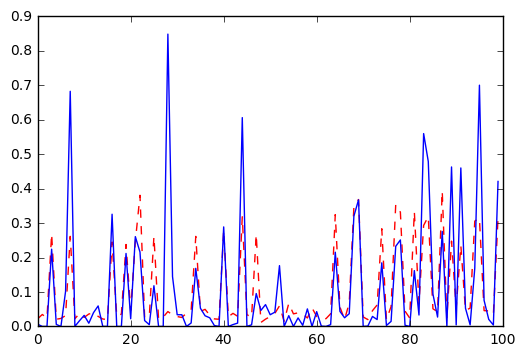

In [79]:
plt.plot(predictions, 'r--')#(np.divide(predictions, 10), 'r--')
plt.plot(measureds)
plt.show()

In [80]:
print (np.corrcoef(predictions,measureds))

[[ 1.          0.71163559]
 [ 0.71163559  1.        ]]
